# UMAP

In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql import *
from pyspark.sql.functions import *
%pip install scikit-learn
from sklearn.datasets import fetch_openml
%pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Demo 1: Load datasets 

### Load dataset

In [ ]:
%ll -r /mnt/eng_data/datasets/stackoverflow-posts/*.parquet | wc -l
# 59  
%ll -r /mnt/eng_data/datasets/OpenMathInstruct-1/*/*.jsonl | wc -l
# 4

# after expanding the OpenMathInstruct-1 dataset into parquet files
%ls /mnt/nfs/datasets/spark3/validation/ | egrep "parquet" | wc -l
# 106865 

In [ ]:
no_stck = get_ipython().run_line_magic('sx', '-q ll -r /mnt/nfs/datasets/stackoverflow-posts/*.parquet | wc -l')
no_stck = int(no_stck[0])
# 59
no_omath = get_ipython().run_line_magic('sx', '-q ll -r /mnt/nfs/datasets/spark3/validation/ | egrep "parquet" | wc -l')
no_omath= int(no_omath[0])
# 106865


Mohan A will provide the PySpark fn to convert OpenMathInstruct dataset jsonl files into parquet files in thousands. (106865 ~= 107k data points)

```python

In [2]:
"""
Load and return Stack Overflow & OpenMathInstruct-1 datasets into Spark 3.4.3 dataFrames of
 59 + 106865 = 106,924 parquet data samples and ??? features across ?? classes.

 Loads the data into a pandas / spark / DataFrame with default datatype float64. (Note that UMAP does not support float64
computation, and will automatically convert inputs to float32 internally).
"""

combinedDf = fetch_openml("/mnt/nfs/datasets/spark3/validation", version=1, parser='auto')
data = text.data
labels = text.target
print(data.shape)
data.info(memory_usage='deep')

(70000, 784)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB


#### Split data into 75% train and 25% test

In [4]:
train_fraction = 0.75

shuffled_indices = np.random.permutation(len(data))
split_idx = int(train_fraction * len(shuffled_indices))
train_indices = shuffled_indices[:split_idx]
test_indices = shuffled_indices[split_idx:]

train_data = data.iloc[train_indices]
train_labels = labels.iloc[train_indices]

test_data = data.iloc[test_indices]
test_labels = labels.iloc[test_indices]

#### Create Spark Session
UMAP is a driver-intensive algorithm. Be sure to allocate enough resources for the driver in the Spark config.

In [5]:
num_threads = 6
driver_memory = "15g"

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    # allocate enough driver memory and set maxResultSize to 0 to avoid serialization limits
    "spark.driver.memory": driver_memory,
    "spark.driver.maxResultSize": "0",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
}
spark = SparkSession.builder.appName("spark-rapids-ml umap")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

23/08/24 13:27:48 WARN Utils: Your hostname, 728fbda-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.44.254 instead (on interface enp1s0)
23/08/24 13:27:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/24 13:27:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Convert dataset to Spark DataFrame

In [6]:
"""Create train dataframe"""
train_df = spark.createDataFrame(train_data)
train_df.cache().count()

23/08/24 13:27:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/08/24 13:27:54 WARN TaskSetManager: Stage 0 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


52500

## Spark RAPIDS ML (GPU)

In [2]:
from spark_rapids_ml.umap import UMAP

In [8]:
feature_cols = [f"pixel{i}" for i in range(1, train_data.shape[1] + 1)]
umap_estimator = UMAP(num_workers=6).setFeaturesCols(feature_cols)

### Fit
Note that fit is executed on a single node, as multi-node fitting is not yet supported.

In [9]:
start_time = time.time()
umap_model = umap_estimator.fit(train_df)
print(f"Fit took: {time.time() - start_time} sec")

23/08/24 13:28:07 WARN TaskSetManager: Stage 3 contains a task of very large size (321791 KiB). The maximum recommended task size is 1000 KiB.
2023-08-24 13:28:10,004 - spark_rapids_ml.umap.UMAP - INFO - Initializing cuml context
2023-08-24 13:28:11,549 - spark_rapids_ml.umap.UMAP - INFO - Loading data into python worker memory
2023-08-24 13:28:16,790 - spark_rapids_ml.umap.UMAP - INFO - Cuml fit complete


Fit took: 16.39893651008606 sec


#### Saving and loading
The UMAP estimator and model can be persisted using the PySpark save() API. Below is an example of saving and loading the model after fitting. The trained embeddings are retained. 

In [10]:
model_path = "/tmp/umap-model"
umap_model.write().overwrite().save(model_path)
umap_model_loaded = umap_model.load(model_path)
print("Model embedding shape:", len(umap_model_loaded.embedding), ",", len(umap_model_loaded.embedding[0]))

Model embedding shape: 52500 , 2


### Transform

In [11]:
"""Create test dataframe"""
feature_cols = [f"pixel{i}" for i in range(1, test_data.shape[1] + 1)]
test_df = spark.createDataFrame(test_data)
test_df.cache().count()

23/08/24 13:28:28 WARN TaskSetManager: Stage 8 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


17500

In [12]:
start_time = time.time()
df_output = umap_model.transform(test_df)
df_output.count()
print(f"Transform took: {time.time() - start_time} sec")

23/08/24 13:28:33 WARN TaskSetManager: Stage 11 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


Transform took: 13.206289291381836 sec


#### Visualize embedding
Notice that UMAP groups individual digit classes while retaining the global structure among different digit classes. 
Groups of digits that may blend together, such as (4, 9) and (3, 5, 8) are embedded near each other, while distinct digits such as (0, 1) are placed far from each other.

23/08/24 13:28:48 WARN TaskSetManager: Stage 14 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


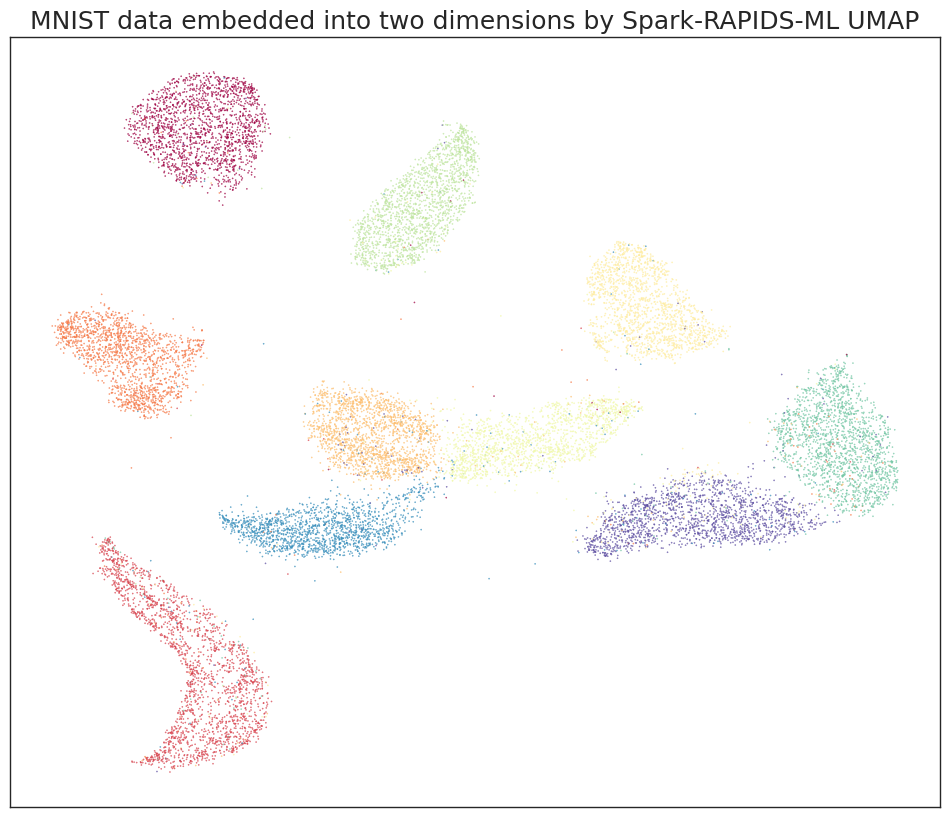

/tmp/ipykernel_2624321/260446261.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


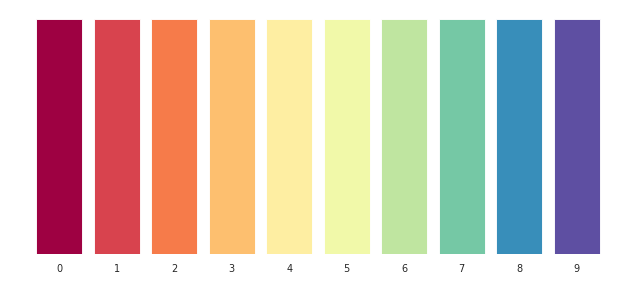

In [13]:
pd_output = df_output.toPandas()
embedding = np.array(pd_output["embedding"].to_list())

# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
color = test_labels.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by Spark-RAPIDS-ML UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()

## UMAP (Local, CPU)

In [ ]:
%pip install umap-learn
import umap as local_cpu_umap

In [15]:
local_umap = local_cpu_umap.UMAP()

### Fit

In [16]:
start_time = time.time()
local_umap.fit(train_data)
print(f"Fit took: {time.time() - start_time} sec")

Fit took: 28.167612314224243 sec


### Transform

In [17]:
start_time = time.time()
embedding = local_umap.transform(test_data)
print(f"Transform took: {time.time() - start_time} sec")

Transform took: 24.39447593688965 sec


### Visualize embedding

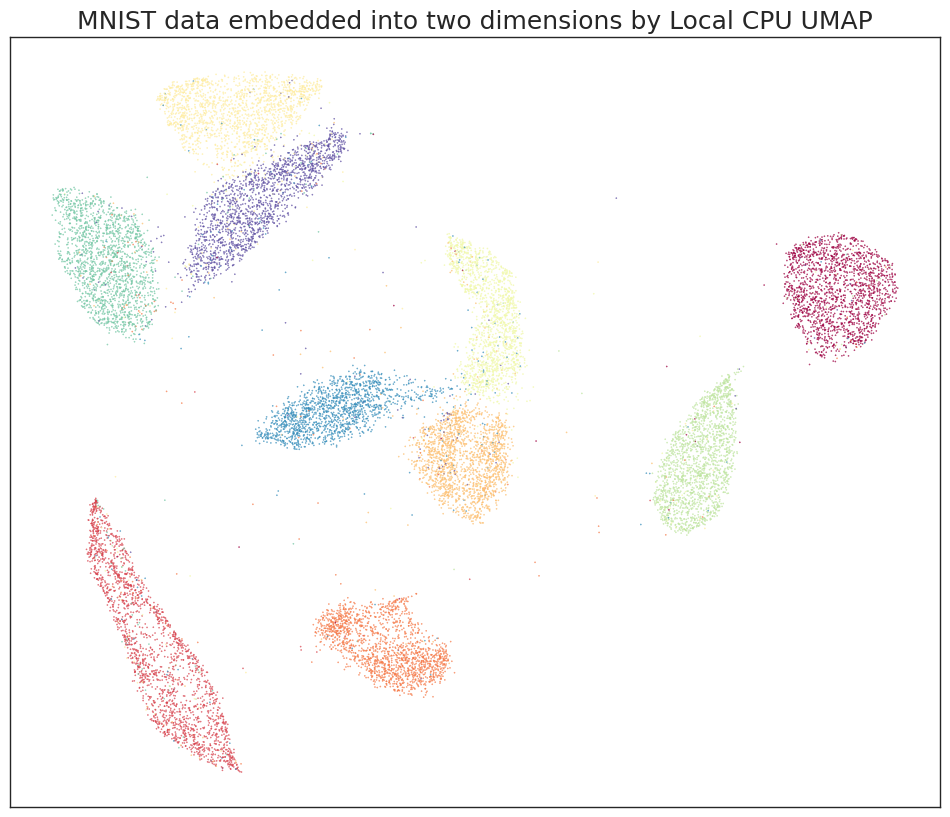

/tmp/ipykernel_2624321/1393456941.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


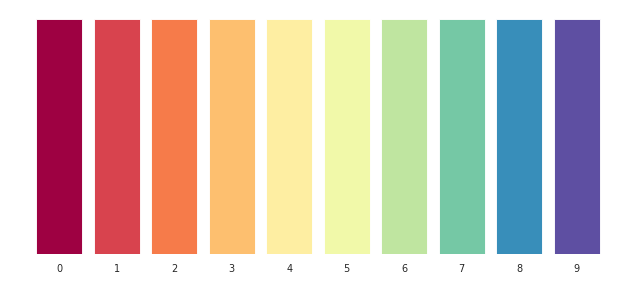

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
color = test_labels.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by Local CPU UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()

## Demo 2: Large blobs dataset

### Load dataset
Below is an example of UMAP on a much larger synthetic clustering dataset.  
Be sure your local machine has enough memory to handle the resultant model and embeddings. Adjust --num_rows and --num_cols accordingly.   
By default, blobs creates a 3-class dataset.

In [19]:
!python ../python/benchmark/gen_data_distributed.py blobs --num_rows 100000 --num_cols 3000 --dtype float32 --output_dir "./blobs_100k_3k_f32.parquet" --feature_type array --include_labels true --overwrite --output_num_files 20 --spark_confs spark.driver.memory=20g --spark_confs spark.master=local[16]

23/08/24 13:30:20 WARN Utils: Your hostname, 728fbda-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.44.254 instead (on interface enp1s0)
23/08/24 13:30:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/24 13:30:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/24 13:30:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Passing {'include_labels': True, 'random_state': 1} to make_blobs
23/08/24 13:30:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
root                                                                            
 |-- label: float (nullable = true)
 |-- feature_array: array

### Download Spark RAPIDS Plugin
The Spark RAPIDS Plugin is included in the Spark config for accelerated and multi-threaded file reading.  

In [4]:
import os
import requests

SPARK_RAPIDS_VERSION = "23.12.1"
cuda_version = "12"
rapids_jar = f"rapids-4-spark_2.12-{SPARK_RAPIDS_VERSION}.jar"

if not os.path.exists(rapids_jar):
    print("Downloading spark rapids jar")
    url = f"https://repo1.maven.org/maven2/com/nvidia/rapids-4-spark_2.12/{SPARK_RAPIDS_VERSION}/rapids-4-spark_2.12-{SPARK_RAPIDS_VERSION}-cuda{cuda_version}.jar"
    response = requests.get(url)
    if response.status_code == 200:
        with open(rapids_jar, "wb") as f:
            f.write(response.content)
        print(f"File '{rapids_jar}' downloaded and saved successfully.")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


#### Create Spark Session
Restart the notebook, if needed, to invoke the new Spark session.

In [5]:
num_threads = 6
driver_memory = "20g"
num_gpus = 1

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": driver_memory,
    "spark.driver.maxResultSize": "0",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
    "spark.rapids.ml.uvm.enabled": "true",
    # accelerated file/parquet reading
    "spark.jars": rapids_jar,
    "spark.executorEnv.PYTHONPATH": rapids_jar,
    "spark.sql.files.minPartitionNum": num_gpus,
    "spark.rapids.memory.gpu.minAllocFraction": "0.0001",
    "spark.plugins": "com.nvidia.spark.SQLPlugin",
    "spark.locality.wait": "0s",
    "spark.sql.cache.serializer": "com.nvidia.spark.ParquetCachedBatchSerializer",
    "spark.rapids.memory.gpu.pooling.enabled": "false",
    "spark.rapids.sql.explain": "ALL",
    "spark.sql.execution.sortBeforeRepartition": "false",
    "spark.rapids.sql.format.parquet.reader.type": "MULTITHREADED",
    "spark.rapids.sql.format.parquet.multiThreadedRead.maxNumFilesParallel": "20",
    "spark.rapids.sql.multiThreadedRead.numThreads": "20",
    "spark.rapids.sql.python.gpu.enabled": "true",
    "spark.rapids.memory.pinnedPool.size": "2G",
    "spark.python.daemon.module": "rapids.daemon",
    "spark.rapids.sql.batchSizeBytes": "512m",
    "spark.sql.adaptive.enabled": "false",
    "spark.sql.files.maxPartitionBytes": "2000000000000",
    "spark.rapids.sql.concurrentGpuTasks": "2",
    "spark.sql.execution.arrow.maxRecordsPerBatch": "20000",
}
spark = SparkSession.builder.appName("spark-rapids-ml umap")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

23/08/24 13:31:17 WARN Utils: Your hostname, 728fbda-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.44.254 instead (on interface enp1s0)
23/08/24 13:31:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/08/24 13:31:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/24 13:31:18 WARN RapidsPluginUtils: RAPIDS Accelerator 23.06.0 using cudf 23.06.0.
23/08/24 13:31:18 WARN RapidsPluginUtils: RAPIDS Accelerator is enabled, to disable GPU support set `spark.rapids.sql.enabled` to false.
23/08/24 13:31:18 WARN RapidsPluginUtils: spark.rapids.sql.explain is set to `ALL`. Set it to 'NONE' to suppress the diagnostics logging about the query placement on the GPU.
23/08/24 13:31:23 WARN GpuDeviceManager: RMM pool is disabled since spark.rapids.memor

## Spark RAPIDS ML (GPU)

In [6]:
blobs_df = spark.read.parquet("blobs_100k_3k_f32.parquet")
umap_estimator = UMAP(num_workers=6).setFeaturesCol("feature_array").setSampleFraction(0.5) # We will use 50% of the data for training.

In [7]:
blobs_df.cache()
blobs_df.show()

23/08/24 13:31:32 WARN GpuOverrides: 
*Exec <FileSourceScanExec> will run on GPU

23/08/24 13:31:33 WARN GpuOverrides: 
!Exec <CollectLimitExec> cannot run on GPU because the Exec CollectLimitExec has been disabled, and is disabled by default because Collect Limit replacement can be slower on the GPU, if huge number of rows in a batch it could help by limiting the number of rows transferred from GPU to CPU. Set spark.rapids.sql.exec.CollectLimitExec to true if you wish to enable it
  @Partitioning <SinglePartition$> could run on GPU
  *Exec <ProjectExec> will run on GPU
    *Expression <Alias> cast(label#0 as string) AS label#16 will run on GPU
      *Expression <Cast> cast(label#0 as string) will run on GPU
    *Expression <Alias> cast(feature_array#1 as string) AS feature_array#17 will run on GPU
      *Expression <Cast> cast(feature_array#1 as string) will run on GPU
    *Exec <InMemoryTableScanExec> will run on GPU



+-----+--------------------+
|label|       feature_array|
+-----+--------------------+
|  0.0|[-1.67173779, 4.3...|
|  0.0|[-2.017143011, 4....|
|  2.0|[2.090506077, 7.4...|
|  2.0|[2.167227268, 8.3...|
|  0.0|[-2.203755856, 3....|
|  1.0|[3.740054607, -8....|
|  2.0|[2.763777018, 7.5...|
|  2.0|[3.651896, 7.5411...|
|  0.0|[-1.376051664, 5....|
|  2.0|[3.414523363, 7.1...|
|  1.0|[7.106060028, -7....|
|  2.0|[4.861860752, 8.2...|
|  0.0|[-1.991874337, 5....|
|  2.0|[3.935755014, 10....|
|  1.0|[5.41667366, -9.6...|
|  2.0|[5.282021046, 6.9...|
|  2.0|[3.548224449, 8.5...|
|  1.0|[5.622824669, -9....|
|  0.0|[-1.853390694, 4....|
|  2.0|[3.241069555, 6.5...|
+-----+--------------------+
only showing top 20 rows



### Fit

In [8]:
start_time = time.time()
umap_model = umap_estimator.fit(blobs_df)
print(f"Fit took: {time.time() - start_time} sec")

23/08/24 13:31:43 WARN GpuOverrides: 
*Exec <SampleExec> will run on GPU
  *Exec <InMemoryTableScanExec> will run on GPU

23/08/24 13:31:43 WARN GpuOverrides: 
!Exec <CollectLimitExec> cannot run on GPU because the Exec CollectLimitExec has been disabled, and is disabled by default because Collect Limit replacement can be slower on the GPU, if huge number of rows in a batch it could help by limiting the number of rows transferred from GPU to CPU. Set spark.rapids.sql.exec.CollectLimitExec to true if you wish to enable it
  @Partitioning <SinglePartition$> could run on GPU
  *Exec <SampleExec> will run on GPU
    *Exec <InMemoryTableScanExec> will run on GPU

2023-08-24 13:31:43,411 - spark_rapids_ml.umap.UMAP - INFO - CUDA managed memory enabled.
23/08/24 13:31:43 WARN GpuOverrides: 
*Exec <ProjectExec> will run on GPU
  *Expression <Alias> embedding_#119 AS col_0#123 will run on GPU
  *Expression <Alias> raw_data_#120 AS col_1#124 will run on GPU
  *Exec <MapInPandasExec> will partial

Fit took: 24.941148281097412 sec


### Transform

In [9]:
start_time = time.time()
df_output = umap_model.transform(blobs_df)
df_output.count()
print(f"Transform took: {time.time() - start_time} sec")

23/08/24 13:32:10 WARN GpuOverrides: 
*Exec <HashAggregateExec> will run on GPU
  *Expression <AggregateExpression> count(1) will run on GPU
    *Expression <Count> count(1) will run on GPU
  *Expression <Alias> count(1)#164L AS count#165L will run on GPU
  *Exec <ShuffleExchangeExec> will run on GPU
    *Partitioning <SinglePartition$> will run on GPU
    *Exec <HashAggregateExec> will run on GPU
      *Expression <AggregateExpression> partial_count(1) will run on GPU
        *Expression <Count> count(1) will run on GPU
      *Exec <ProjectExec> will run on GPU
        *Exec <MapInPandasExec> will partially run on GPU
          *Expression <PythonUDF> _transform_udf(label#0, feature_array#1)#157 will not block GPU acceleration
          *Exec <InMemoryTableScanExec> will run on GPU



Transform took: 13.75040888786316 sec


### Visualize embedding
Note that the 100,000 samples with 3000 features were mapped into 3 distinct clusters in 2 dimensions.

23/08/24 13:32:27 WARN GpuOverrides: 
*Exec <ProjectExec> will run on GPU
  *Expression <Alias> features#158 AS col_0#213 will run on GPU
  *Expression <Alias> embedding#159 AS col_1#214 will run on GPU
  *Exec <MapInPandasExec> will partially run on GPU
    *Expression <PythonUDF> _transform_udf(label#0, feature_array#1)#157 will not block GPU acceleration
    *Exec <InMemoryTableScanExec> will run on GPU

23/08/24 13:32:49 WARN GpuOverrides:                                            
*Exec <ProjectExec> will run on GPU
  *Expression <Alias> label#0 AS col_0#248 will run on GPU
  *Exec <InMemoryTableScanExec> will run on GPU



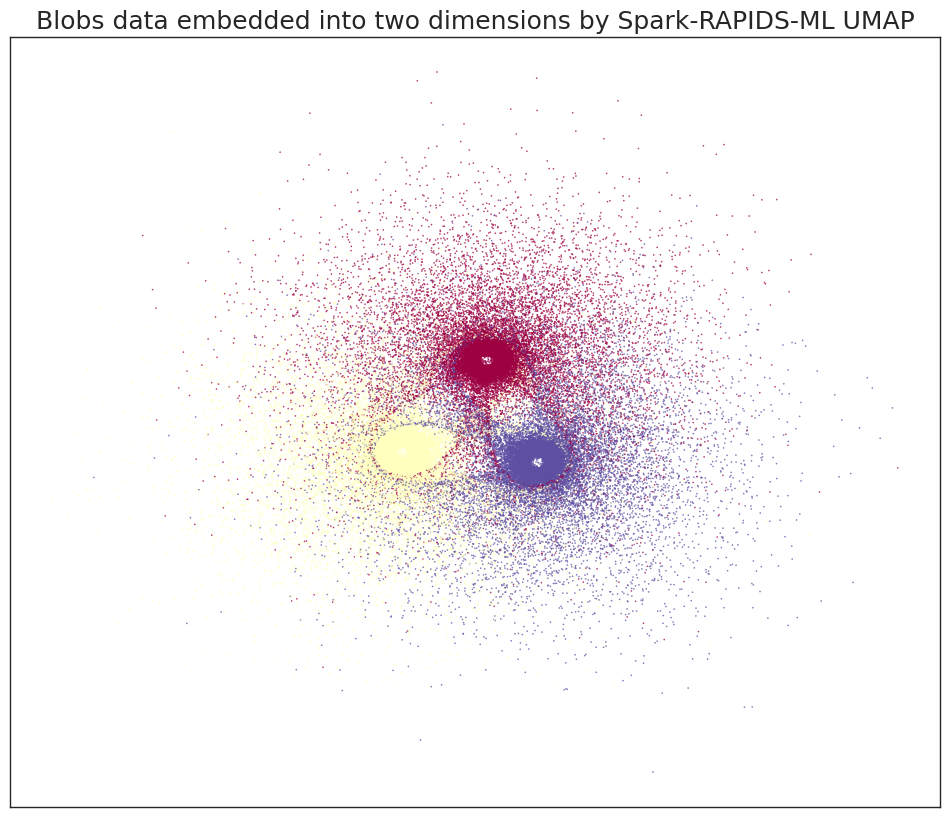

In [10]:
pd_output = df_output.toPandas()
embedding = np.array(pd_output["embedding"].to_list())

# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
color = blobs_df.select("label").toPandas()["label"].values.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Blobs data embedded into two dimensions by Spark-RAPIDS-ML UMAP", fontsize=18)
plt.show()

## UMAP (Local, CPU)

In [11]:
local_umap = local_cpu_umap.UMAP()

### Convert dataframe to numpy

In [12]:
blobs_singlecol = blobs_df.drop("label").toPandas().to_numpy()
blobs = np.array([array[0] for array in blobs_singlecol], dtype=np.float32)
print(blobs.shape)

23/08/24 13:32:56 WARN GpuOverrides: 
*Exec <ProjectExec> will run on GPU
  *Expression <Alias> feature_array#1 AS col_0#281 will run on GPU
  *Exec <InMemoryTableScanExec> will run on GPU



(100000, 3000)


We will use 50% of the data for training.

In [14]:
train_fraction = 0.5

shuffled_indices = np.random.permutation(blobs.shape[0])
split_idx = int(train_fraction * len(shuffled_indices))
sampled_indices = shuffled_indices[:split_idx]

blobs_train = blobs[sampled_indices]
print(blobs_train.shape)

(50000, 3000)


### Fit

In [15]:
start_time = time.time()
local_umap.fit(blobs_train)
print(f"Fit took: {time.time() - start_time} sec")

Fit took: 40.58121943473816 sec


### Transform

In [16]:
start_time = time.time()
embedding = local_umap.transform(blobs)
print(f"Transform took: {time.time() - start_time} sec")

Transform took: 1293.3682293891907 sec


### Visualize embedding

23/08/24 13:55:28 WARN GpuOverrides: 
*Exec <ProjectExec> will run on GPU
  *Expression <Alias> label#0 AS col_0#314 will run on GPU
  *Exec <InMemoryTableScanExec> will run on GPU



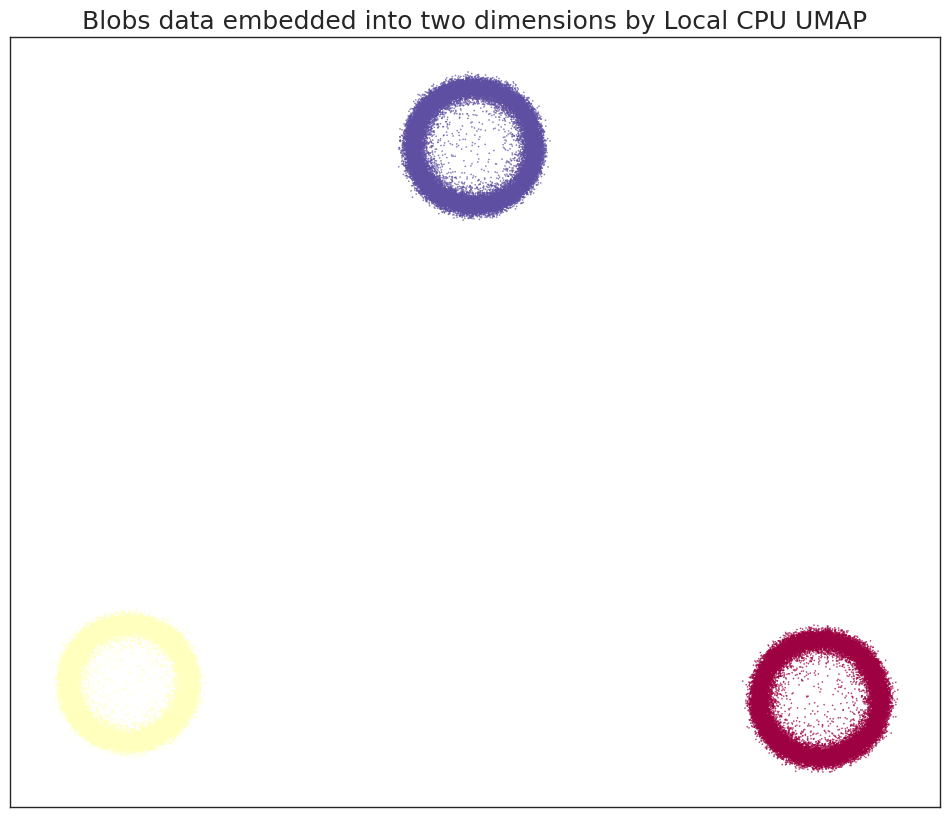

In [17]:
# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
color = blobs_df.select("label").toPandas()["label"].values.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Blobs data embedded into two dimensions by Local CPU UMAP", fontsize=18)
plt.show()

Note that there may be visualization differences above, as reported in this [issue](https://github.com/lmcinnes/umap/issues/775).  
This is due to differences in the CPU and GPU implementations regarding embedding optimization and handling scaling/outliers.